## Data Loading

Load original dataset and preprocess the loaded data.

- data_name: stock, energy, or sine
- seq_len: sequence length of the time-series data

In [1]:
from data_loading import real_data_loading
from data_loading import real_data_processing
from data_loading import label_data

In [2]:
# --- Data loading ---
data_name = "AAPL"
seq_len = 60
start_date = "2005-01-01"
end_date = "2024-11-10"

ori_data = real_data_loading(data_name, start_date, end_date)

print(f"{data_name} dataset is ready. Number of sequences: {len(ori_data)}")

AAPL dataset is ready. Number of sequences: 4979


In [3]:
print(ori_data.head())

all_names = ori_data.columns.get_level_values(0)
feature_names= all_names.tolist()
print(feature_names)

Price      Adj Close     Close      High       Low      Open      Volume  \
Ticker          AAPL      AAPL      AAPL      AAPL      AAPL        AAPL   
Date                                                                       
2005-01-31  1.153155  1.373214  1.390893  1.330536  1.331786  1681097600   
2005-02-01  1.162603  1.384464  1.388750  1.367500  1.375893   678395200   
2005-02-02  1.194093  1.421964  1.426964  1.387321  1.391964  1020062400   
2005-02-03  1.166802  1.389464  1.418393  1.380893  1.412500   731651200   
2005-02-04  1.182247  1.407857  1.409464  1.384464  1.390536   563556000   

Price      Log_Return       ATR       BBW      MACD MACD_Signal        RSI  
Ticker                                                                      
Date                                                                        
2005-01-31   0.038711  0.043237  0.214918  0.047071    0.036300  88.590696  
2005-02-01   0.008159  0.040306  0.222039  0.051872    0.039414  89.490280  
2005-0

In [4]:
# --- Data Processing ---
ori_data_x = real_data_processing(ori_data, seq_len)
print(len(ori_data_x))
print(ori_data_x[0].shape)

4919
(60, 12)



Step 1: Calculating metrics for 4919 windows...
Metric calculation complete.

Step 2: Applying two-stage labeling...
  - Crisis MDD Threshold (90.0th percentile): 0.2750
  - Volatile Vol Threshold (85.0th percentile of non-crisis): 0.0248
Labeling complete.

--- Labeling Results ---
Final Label Distribution:
label
Normal      76.5%
Volatile    13.5%
Crisis      10.0%
Name: proportion, dtype: object

Step 3: Creating final one-hot encoded list...
Finished. 'ori_data_s' is a list of length 4919.

Example 'ori_data' item shape: (60, 12)
Example 'ori_data_s' item: [1.0, 0.0, 0.0]

Example 'ori_data' item (another): (60, 12)
Example 'ori_data_s' item (another): [1.0, 0.0, 0.0]

Total length of 'ori_data': 4919
Total length of 'ori_data_s': 4919

Generating visualization of labeled clusters...
Saved cluster visualization to 'market_regime_clusters.png'


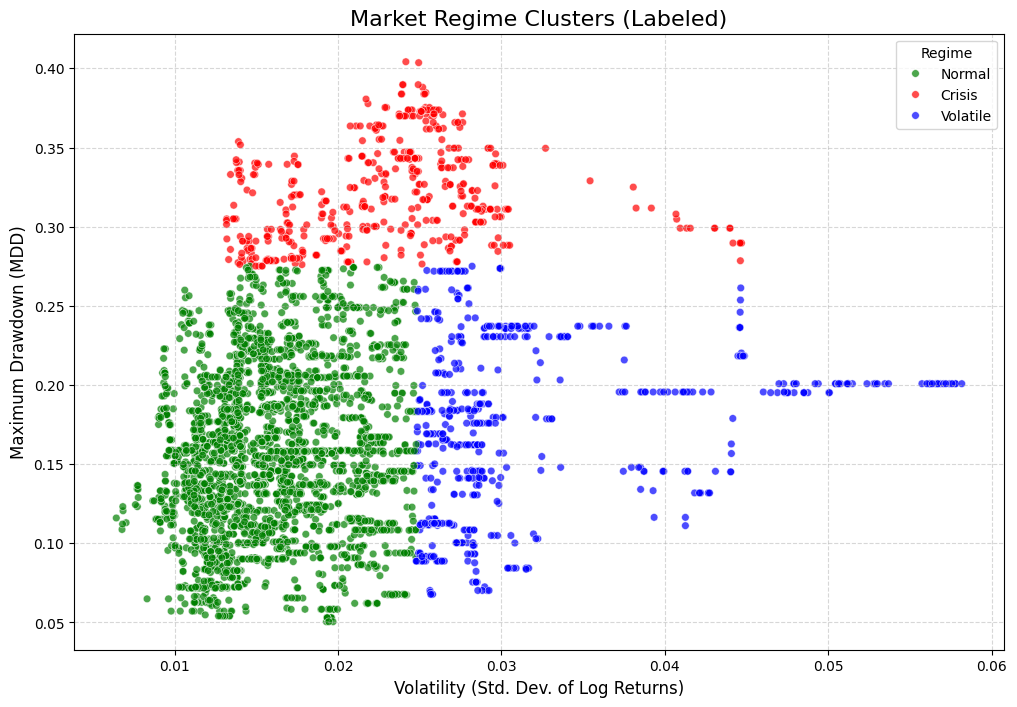

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


#########################################################################
# --- MAIN EXECUTION ---
#########################################################################

# Your feature names in the correct order
feature_names = [
    'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume',
    'Log_Return', 'ATR', 'BBW', 'MACD', 'MACD_Signal', 'RSI'
]

# Run the labeling function
# 'ori_data' is the list you created in your previous code
ori_data_s, metrics_df = label_data(ori_data_x, feature_names)

# --- Check the results ---
if ori_data_s:
    print(f"\nExample 'ori_data' item shape: {ori_data_x[0].shape}")
    print(f"Example 'ori_data_s' item: {ori_data_s[0]}")

    print(f"\nExample 'ori_data' item (another): {ori_data_x[-1].shape}")
    print(f"Example 'ori_data_s' item (another): {ori_data_s[-1]}")

    print(f"\nTotal length of 'ori_data': {len(ori_data_x)}")
    print(f"Total length of 'ori_data_s': {len(ori_data_s)}")

    # --- Optional Visualization ---
    # This plot helps you confirm the labels make sense
    print("\nGenerating visualization of labeled clusters...")
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        data=metrics_df,
        x='volatility',
        y='mdd',
        hue='label',
        palette={'Normal': 'g', 'Volatile': 'b', 'Crisis': 'r'},
        alpha=0.7,
        s=30
    )
    plt.title('Market Regime Clusters (Labeled)', fontsize=16)
    plt.xlabel('Volatility (Std. Dev. of Log Returns)', fontsize=12)
    plt.ylabel('Maximum Drawdown (MDD)', fontsize=12)
    plt.legend(title='Regime')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.savefig("market_regime_clusters.png")
    print("Saved cluster visualization to 'market_regime_clusters.png'")

In [6]:
## Necessary packages
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import warnings
warnings.filterwarnings("ignore")

# 1. TimeGAN model
from timegan import timegan
from timegan import generate_data_from_saved_models
# 3. Metrics
from metrics.discriminative_metrics import discriminative_score_metrics
from metrics.predictive_metrics import predictive_score_metrics
from metrics.visualization_metrics import visualization

2025-11-11 14:56:21.010985: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-11 14:56:21.095289: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-11 14:56:23.185386: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


## Set network parameters

TimeGAN network parameters should be optimized for different datasets.

- module: gru, lstm, or lstmLN
- hidden_dim: hidden dimensions
- num_layer: number of layers
- iteration: number of training iterations
- batch_size: the number of samples in each batch

In [7]:
## Newtork parameters
parameters = dict()

parameters['module'] = 'gru'
parameters['hidden_dim'] = 24
parameters['num_layer'] = 3
parameters['iterations'] = 22
parameters['batch_size'] = 64

## Run TimeGAN for synthetic time-series data generation

TimeGAN uses the original data and network parameters to return the generated synthetic data.

In [8]:
# Train Timegan
timegan(ori_data_s, ori_data_x, parameters)

2025-11-11 14:56:24.232473: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Start Embedding Network Training
step: 0/22, e_loss: 0.5216000080108643
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 0/22, s_loss: 0.1378999948501587
Finish Training with Supervised Loss Only
Start Joint Training
step: 0/22, d_loss: 4.052800178527832, g_loss_u: 1.6366000175476074, g_loss_s: 0.07020000368356705, g_loss_v: 0.6955999732017517, e_loss_t0: 0.42800000309944153


step: 21/22, d_loss: 3.9209001064300537, g_loss_u: 2.134500026702881, g_loss_s: 0.15309999883174896, g_loss_v: 0.5831000208854675, e_loss_t0: 0.39989998936653137
Finish Joint Training
Saving trained models and scalers...
Models and scalers saved to saved_models/


In [9]:
# Run TimeGAN
generated_data_s, generated_data_x = generate_data_from_saved_models(ori_data_s, ori_data_x)
print('Finish Synthetic Data Generation')

Loading pre-trained models and scalers...


Models loaded successfully.
Generating synthetic data...
Data generation complete.
Finish Synthetic Data Generation


In [10]:
normal_idx = []
crisis_idx = []
vol_idx = []
for i in range(len(generated_data_s)):
    if np.argmax(generated_data_s[i]) == 0:
        normal_idx.append(i)
    elif np.argmax(generated_data_s[i]) == 1:
        crisis_idx.append(i)
    else:
        vol_idx.append(i)

generated_data_x_n = []
for i in range(len(normal_idx)):
    generated_data_x_n.append(generated_data_x[normal_idx[i]])
generated_data_x_c = []
for i in range(len(crisis_idx)):
    generated_data_x_c.append(generated_data_x[crisis_idx[i]])
generated_data_x_v = []
for i in range(len(vol_idx)):
    generated_data_x_v.append(generated_data_x[vol_idx[i]])

nor_idx = []
cri_idx = []
vo_idx = []
for i in range(len(ori_data_s)):
    if ori_data_s[i] == [1.0,0.0,0.0]:
        nor_idx.append(i)
    elif ori_data_s[i] == [0.0,1.0,0.0]:
        cri_idx.append(i)
    else:
        vo_idx.append(i)

ori_data_x_n = []
for i in range(len(nor_idx)):
    ori_data_x_n.append(ori_data_x[nor_idx[i]])
ori_data_x_c = []
for i in range(len(cri_idx)):
    ori_data_x_c.append(ori_data_x[cri_idx[i]])
ori_data_x_v = []
for i in range(len(vo_idx)):
    ori_data_x_v.append(ori_data_x[vo_idx[i]])

print(len(generated_data_x_n))
print(len(ori_data_x_n))
print("/\n")
print(len(generated_data_x_c))
print(len(ori_data_x_c))
print("/\n")
print(len(generated_data_x_v))
print(len(ori_data_x_v))
print("/\n")


# print(ori_data_s[0])


4919
3763
/

0
492
/

0
664
/



In [ ]:
import pickle
with open('generated_data_x_n.pkl', 'wb') as f:
    pickle.dump(generated_data_x_n, f)
with open('generated_data_x_c.pkl', 'wb') as f:
    pickle.dump(generated_data_x_c, f)
with open('generated_data_x_v.pkl', 'wb') as f:
    pickle.dump(generated_data_x_v, f)
with open('ori_data_x_n.pkl', 'wb') as f:
    pickle.dump(ori_data_x_n, f)
with open('ori_data_x_c.pkl', 'wb') as f:
    pickle.dump(ori_data_x_c, f)
with open('ori_data_x_v.pkl', 'wb') as f:
    pickle.dump(ori_data_x_v, f)

# LOADING

In [11]:
import pickle
with open('generated_data_x_n.pkl', 'rb') as f:
    generated_data_x_loaded_n = pickle.load(f)
with open('generated_data_x_c.pkl', 'rb') as f:
    generated_data_x_loaded_c = pickle.load(f)
with open('generated_data_x_v.pkl', 'rb') as f:
    generated_data_x_loaded_v = pickle.load(f)
with open('ori_data_x_n.pkl', 'rb') as f:
    ori_data_x_loaded_n = pickle.load(f)
with open('ori_data_x_c.pkl', 'rb') as f:
    ori_data_x_loaded_c = pickle.load(f)
with open('ori_data_x_v.pkl', 'rb') as f:
    ori_data_x_loaded_v = pickle.load(f)

# Evaluate the generated data

## Normal

In [12]:
len_ori_data_n = len(ori_data_x_loaded_n)
len_gen_data_n = len(generated_data_x_loaded_n)
print(len_gen_data_n)
print(len_ori_data_n)

3654
3763


### 1. Discriminative score

In [ ]:
metric_iteration = 5

discriminative_score = list()
for _ in range(metric_iteration):
  if len_ori_data_n > len_gen_data_n:
    temp_disc = discriminative_score_metrics(ori_data_x_loaded_n[:len_gen_data_n], generated_data_x_loaded_n)
  else:
    temp_disc = discriminative_score_metrics(ori_data_x_loaded_n, generated_data_x_loaded_n[:len_ori_data_n])
  discriminative_score.append(temp_disc)

print('Discriminative score: ' + str(np.round(np.mean(discriminative_score), 4)))

### 2. Predictive score

In [ ]:
predictive_score = list()
for _ in range(metric_iteration):
  if len_ori_data_n > len_gen_data_n:
    temp_disc = predictive_score_metrics(ori_data_x_loaded_n[:len_gen_data_n], generated_data_x_loaded_n)
  else:
    temp_disc = predictive_score_metrics(ori_data_x_loaded_n, generated_data_x_loaded_n[:len_ori_data_n])
  predictive_score.append(temp_disc)

print('predictive score: ' + str(np.round(np.mean(predictive_score), 4)))

### Visualisation

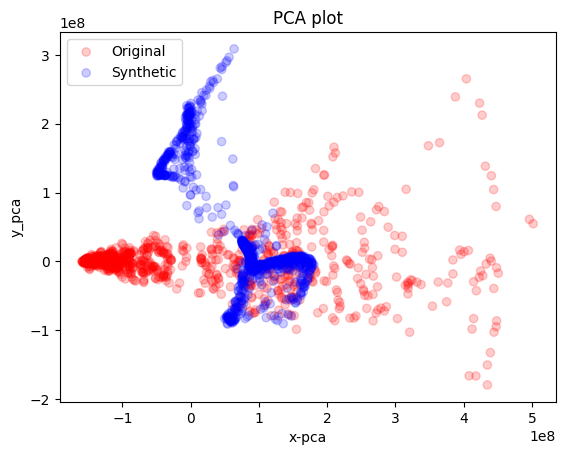

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.285s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 12688873.439558
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.050568
[t-SNE] KL divergence after 300 iterations: 1.201215


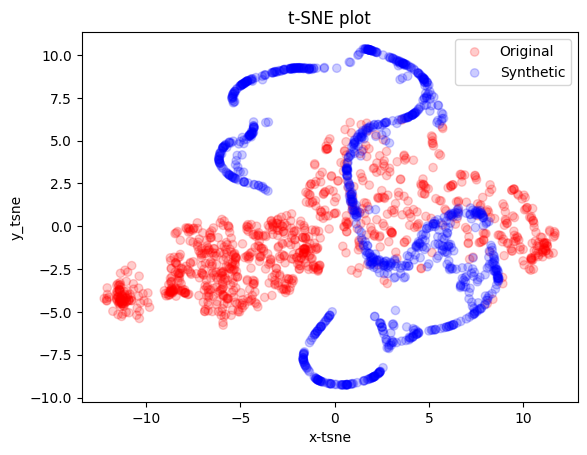

In [13]:
if len_ori_data_n < len_gen_data_n:
    visualization(ori_data_x_loaded_n, generated_data_x_loaded_n[:len(ori_data_x_loaded_n)], 'pca')
    visualization(ori_data_x_loaded_n, generated_data_x_loaded_n[:len(ori_data_x_loaded_n)], 'tsne')
else:
    visualization(ori_data_x_loaded_n[:len(generated_data_x_loaded_n)], generated_data_x_loaded_n, 'pca')
    visualization(ori_data_x_loaded_n[:len(generated_data_x_loaded_n)], generated_data_x_loaded_n, 'tsne')

## Crisis

In [15]:
len_ori_data_c = len(ori_data_x_loaded_c)
len_gen_data_c = len(generated_data_x_loaded_c)

### 1. Discriminative score

In [ ]:
discriminative_score = list()
for _ in range(metric_iteration):
  if len_ori_data_c > len_gen_data_c:
    temp_disc = discriminative_score_metrics(ori_data_x_loaded_c[:len_gen_data_c], generated_data_x_loaded_c)
  else:
    temp_disc = discriminative_score_metrics(ori_data_x_loaded_c, generated_data_x_loaded_c[:len_ori_data_c])
  discriminative_score.append(temp_disc)

print('Discriminative score: ' + str(np.round(np.mean(discriminative_score), 4)))

### 2. Predictive score

In [ ]:
predictive_score = list()
for _ in range(metric_iteration):
  if len_ori_data_c > len_gen_data_c:
    temp_disc = predictive_score_metrics(ori_data_x_loaded_c[:len_gen_data_c], generated_data_x_loaded_c)
  else:
    temp_disc = predictive_score_metrics(ori_data_x_loaded_c, generated_data_x_loaded_c[:len_ori_data_c])
  predictive_score.append(temp_disc)

print('predictive score: ' + str(np.round(np.mean(predictive_score), 4)))

### 3. Visualisation

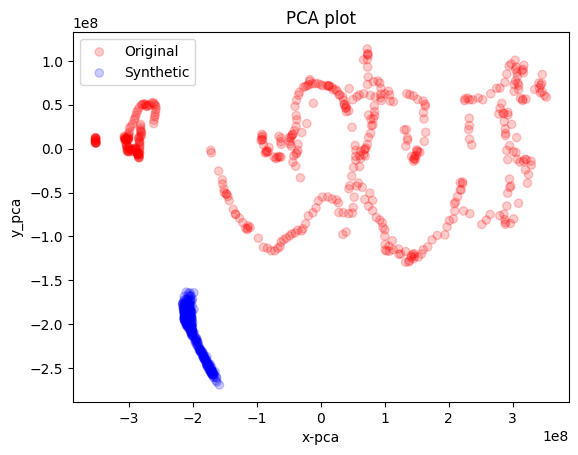

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 984 samples in 0.001s...
[t-SNE] Computed neighbors for 984 samples in 0.033s...
[t-SNE] Computed conditional probabilities for sample 984 / 984
[t-SNE] Mean sigma: 31942415.202796
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.247128
[t-SNE] KL divergence after 300 iterations: 0.595215


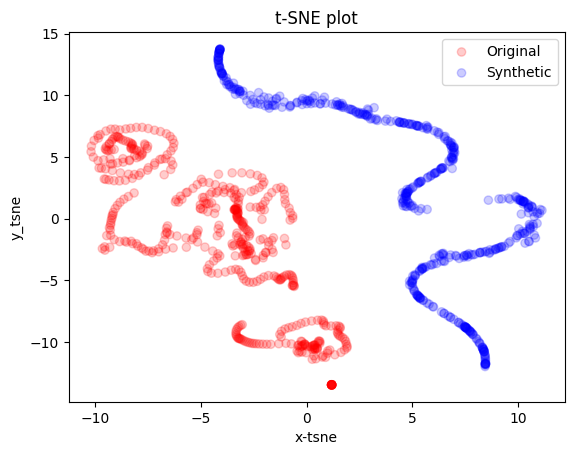

In [16]:
if len_ori_data_c < len_gen_data_c:
    visualization(ori_data_x_loaded_c, generated_data_x_loaded_c[:len(ori_data_x_loaded_c)], 'pca')
    visualization(ori_data_x_loaded_c, generated_data_x_loaded_c[:len(ori_data_x_loaded_c)], 'tsne')
else:
    visualization(ori_data_x_loaded_c[:len(generated_data_x_loaded_c)], generated_data_x_loaded_c, 'pca')
    visualization(ori_data_x_loaded_c[:len(generated_data_x_loaded_c)], generated_data_x_loaded_c, 'tsne')

## Volatile

In [17]:
len_ori_data_v = len(ori_data_x_loaded_v)
len_gen_data_v = len(generated_data_x_loaded_v)

### 1. Discriminative Score

In [ ]:
discriminative_score = list()
for _ in range(metric_iteration):
  if len_ori_data_v > len_gen_data_v:
    temp_disc = discriminative_score_metrics(ori_data_x_loaded_v[:len_gen_data_v], generated_data_x_loaded_v)
  else:
    temp_disc = discriminative_score_metrics(ori_data_x_loaded_v, generated_data_x_loaded_v[:len_ori_data_v])
  discriminative_score.append(temp_disc)

print('Discriminative score: ' + str(np.round(np.mean(discriminative_score), 4)))

### 2. Predictive Score

In [ ]:
predictive_score = list()
for _ in range(metric_iteration):
  if len_ori_data_v > len_gen_data_v:
    temp_disc = predictive_score_metrics(ori_data_x_loaded_v[:len_gen_data_v], generated_data_x_loaded_v)
  else:
    temp_disc = predictive_score_metrics(ori_data_x_loaded_v, generated_data_x_loaded_v[:len_ori_data_v])
  predictive_score.append(temp_disc)

print('predictive score: ' + str(np.round(np.mean(predictive_score), 4)))

### 3. Visualisation

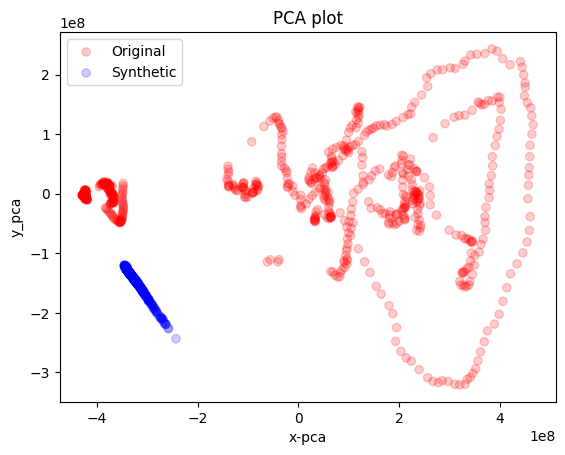

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1328 samples in 0.001s...
[t-SNE] Computed neighbors for 1328 samples in 0.067s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1328
[t-SNE] Computed conditional probabilities for sample 1328 / 1328
[t-SNE] Mean sigma: 11808231.157627
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.268177
[t-SNE] KL divergence after 300 iterations: 0.892796


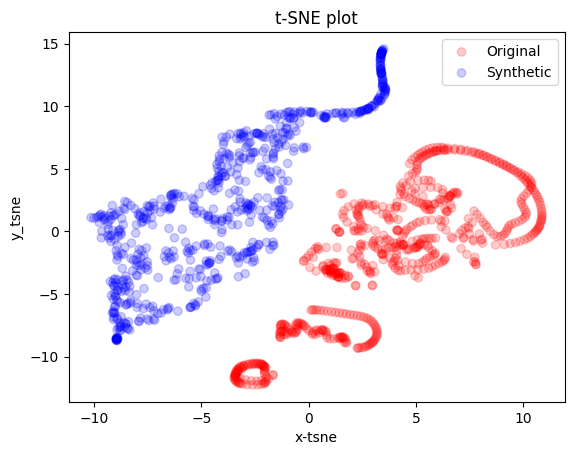

In [18]:
if len_ori_data_v < len_gen_data_v:
    visualization(ori_data_x_loaded_v, generated_data_x_loaded_v[:len(ori_data_x_loaded_v)], 'pca')
    visualization(ori_data_x_loaded_v, generated_data_x_loaded_v[:len(ori_data_x_loaded_v)], 'tsne')
else:
    visualization(ori_data_x_loaded_v[:len(generated_data_x_loaded_v)], generated_data_x_loaded_v, 'pca')
    visualization(ori_data_x_loaded_v[:len(generated_data_x_loaded_v)], generated_data_x_loaded_v, 'tsne')